In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [54]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [55]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [56]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [57]:
INPUT_DIM = 7
OUTPUT_DIM = 7

In [58]:
dims = [INPUT_DIM, 256, 256, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [59]:
target_dims = [INPUT_DIM, 10, OUTPUT_DIM]
Target_TBNN = bnn.network.TernBinNetwork(
    *target_dims,
    forward_func=forward_func,
    backward_func=None,
)
Target_TBNN._initialise(W_mean=0, W_zero_prob=0.8)

In [60]:
TN_DL = bnn.data.TargetNetworkDataLoader(
    target_network=Target_TBNN,
    datapoints=1000,
    batch_size=1000,
    include_last_if_uneven=True,
)

UnaryDL = bnn.data.AllUnaryFunctionsDataLoader(
    input_dim=1,
    datapoints=100,
    batch_size=100,
    include_last_if_uneven=True
)

DL = TN_DL

In [61]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [62]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.0005)

In [63]:
losses = []

In [64]:
train_epochs = 500
num_logs = 10
epoch_log_rate = train_epochs // num_logs

In [65]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=BernOpt, gamma=1.)

In [66]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    for batch in DL:
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss)

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

    scheduler.step()

  0%|          | 1/500 [00:00<02:19,  3.57it/s]

epoch: 0	loss: 7144


 10%|█         | 52/500 [00:14<01:52,  3.97it/s]

epoch: 50	loss: 526


 20%|██        | 101/500 [00:27<01:37,  4.09it/s]

epoch: 100	loss: 396


 30%|███       | 151/500 [00:40<01:14,  4.68it/s]

epoch: 150	loss: 158


 40%|████      | 201/500 [00:54<01:54,  2.61it/s]

epoch: 200	loss: 98


 48%|████▊     | 242/500 [01:06<01:10,  3.65it/s]

epoch: 242	loss: 0


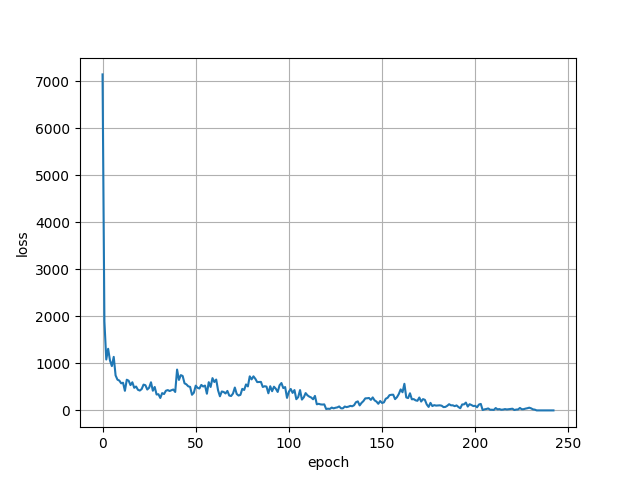

In [67]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [68]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 0,  1,  0,  ..., -1,  0,  0],
        [ 0,  1, -1,  ...,  1,  0,  0],
        [ 0,  1, -1,  ..., -1,  0,  1],
        ...,
        [ 1,  1,  1,  ...,  0, -1, -1],
        [ 1,  1,  0,  ...,  0,  0, -1],
        [ 1, -1,  1,  ...,  0, -1,  0]], dtype=torch.int32) 
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 0,  0, -1,  ...,  0, -1,  1],
        [ 0,  0,  1,  ...,  0,  1,  0],
        [-1,  1, -1,  ...,  0,  1,  0],
        ...,
        [ 0, -1,  0,  ..., -1, -1, -1],
        [ 0,  0,  1,  ..., -1,  0, -1],
        [ 0, -1,  1,  ...,  1,  0,  0]], dtype=torch.int32) 
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
    

In [69]:
assert bnn.network.network_params_al_ternary(TBNN)